
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [26]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from gensim.models import KeyedVectors
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

In [31]:
embedding_model = KeyedVectors.load_word2vec_format('../embeddings/wiki.pt.vec')

In [32]:
df = pd.read_csv('../datasets/buscape_preprocessed.csv')

In [33]:
print(f'{df.shape[0]} instancias, {df.shape[1]} classes')

133632 instancias, 2 classes


In [34]:
df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


In [35]:
df['rating'].value_counts()

rating
1    66816
0    66816
Name: count, dtype: int64

In [36]:
texts = df.review_text
labels = df.rating

In [37]:
def get_average_embedding(text):
    words = str(text).split()
    embeddings = [embedding_model[word] for word in words if word in embedding_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)

In [38]:
X_embeddings = np.array([get_average_embedding(text) for text in texts])

In [39]:
print(f'{X_embeddings.shape[0]} sentenças, {X_embeddings.shape[1]} dimensoes')

133632 sentenças, 300 dimensoes


In [40]:
DROPOUT = 0.05 # 5%, 15%, 25%, 35%, and 50%
LEARNING_RATE = 5e-3 # 5e-4, 1e-3, 5e-3, 1e-2
K_FOLDS = 10
EPOCHS = 5
LOSS = 'binary_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 32
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]
VERBOSE=1

In [41]:
model = Sequential()
model.add(Input(300,)),
model.add(Dense(24, activation='relu')),
model.add(Dropout(DROPOUT)),
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 24)                7224      
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Funcao responsavel por carregar os pesos do treinamento anterior extensão .hdf5
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

In [43]:
# Acoplando os pesos ao modelo
fast_text_mlp_hdf5_weight_path = './weights/fast_text_mlp_weights.hdf5'
model = load_weights_from_hdf5(model, fast_text_mlp_hdf5_weight_path)

In [44]:
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

In [45]:
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

In [46]:
fold = 0

train_loss_history = []
train_accuracies = []
train_f1_scores = []

val_f1_scores = []
val_accuracies = []
for train_idx, val_idx in skf.split(X_embeddings, labels):
    fold += 1
    print(f'fold ---> {fold}')
    
    X_train, X_val = X_embeddings[train_idx], X_embeddings[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    model_history = model.fit(
        X_train, 
        y_train, 
        verbose=VERBOSE, 
        batch_size=BATCH_SIZE,  
        epochs=EPOCHS,
        validation_data=(X_train, y_train),
        callbacks=CALLBACKS
    )
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracies.append(model_history.history['accuracy'])
    
    y_pred_train = (model.predict(X_train) > 0.5).astype(int)
    
    train_f1_score = f1_score(y_train, y_pred_train)
    train_f1_scores.append(train_f1_score)
    
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    
    val_fold_f1_score = f1_score(y_val, y_pred)
    val_f1_scores.append(val_fold_f1_score)
    
    val_accuracy = accuracy_score(y_val, y_pred)
    val_accuracies.append(val_accuracy)

print('Finished!')

fold ---> 1
Epoch 1/5
3759/3759 [==============================] - 8s 2ms/step - loss: 0.4157 - accuracy: 0.8186 - val_loss: 0.4063 - val_accuracy: 0.8163
Epoch 2/5
3759/3759 [==============================] - 7s 2ms/step - loss: 0.3867 - accuracy: 0.8311 - val_loss: 0.3749 - val_accuracy: 0.8353
Epoch 3/5
3759/3759 [==============================] - 7s 2ms/step - loss: 0.3719 - accuracy: 0.8387 - val_loss: 0.3494 - val_accuracy: 0.8493
Epoch 4/5
3759/3759 [==============================] - 7s 2ms/step - loss: 0.3631 - accuracy: 0.8419 - val_loss: 0.3373 - val_accuracy: 0.8562
Epoch 5/5
418/418 [==============================] - 0s 738us/step
fold ---> 2
Epoch 1/5
3759/3759 [==============================] - 10s 3ms/step - loss: 0.3467 - accuracy: 0.8489 - val_loss: 0.3274 - val_accuracy: 0.8612
Epoch 2/5
3759/3759 [==============================] - 7s 2ms/step - loss: 0.3391 - accuracy: 0.8528 - val_loss: 0.3367 - val_accuracy: 0.8548
Epoch 3/5
3759/3759 [=============================

In [65]:
print(f"mean train f1 scores: {np.mean(train_f1_scores)}")

mean_fold_train_accuracies = np.mean([np.mean(train_acc) for train_acc in train_accuracies])
print(f"mean train acc: {np.mean(mean_fold_train_accuracies)}")

print('-'*40)

print(f'mean_val_accuracy = {np.mean(val_accuracies)}')
print(f'mean_val_f1_score = {np.mean(val_f1_scores)}')

mean train f1 scores: 0.8895953121789961
mean train acc: 0.8757499730587005
----------------------------------------
mean_val_accuracy = 0.8820271048891672
mean_val_f1_score = 0.8862778258482479


In [66]:
graph_path = './graphs/05_fasttext_mlp_finetuning/'

In [67]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'{graph_path}train_test_{metric}.png')
    plt.show()
    
def plot_k_folds_metrics(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'{graph_path}folds_{metric}.png')
    plt.show()
    
def plot_train_f1_score(metrics_list, k_folds_list, metric_name):
    folds = list(range(1,k_folds_list+1))
    val_acc = metrics_list
    plt.figure(figsize=(6, 4))
    plt.plot(folds, val_acc, marker='o')
    plt.title(f'Train {metric_name} Over Folds')
    plt.xlabel('Folds')
    plt.ylabel(f'Train {metric_name}')
    plt.grid(True)
    plt.xticks(folds)
    plt.ylim(0.8, 1.0)
    plt.savefig(f'{graph_path}f1_sc_{metric_name}.png')
    plt.show()
    
def plot_validation_graphs(metrics_list, k_folds_list, metric_name):
    folds = list(range(1,k_folds_list+1))
    val_acc = metrics_list
    plt.figure(figsize=(6, 4))
    plt.plot(folds, val_acc, marker='o')
    plt.title(f'Validation {metric_name} Over Folds')
    plt.xlabel('Folds')
    plt.ylabel(f'Validation {metric_name}')
    plt.grid(True)
    plt.xticks(folds)
    plt.ylim(0.8, 1.0)
    plt.savefig(f'{graph_path}val_{metric_name}.png')
    plt.show()

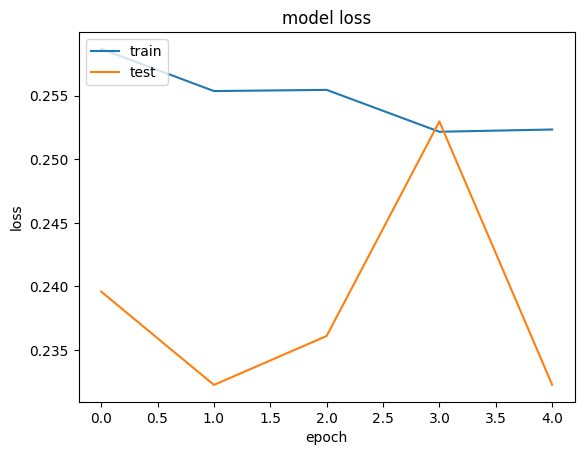

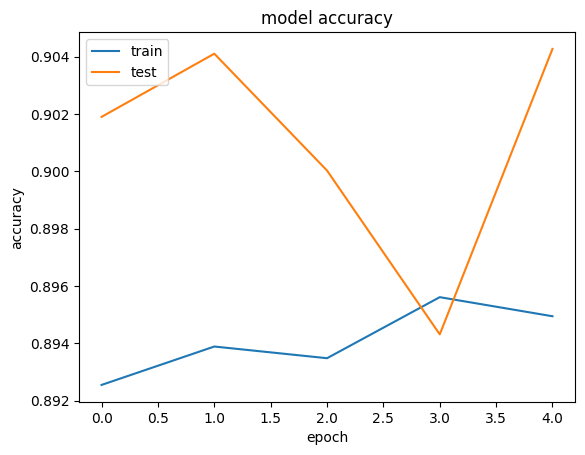

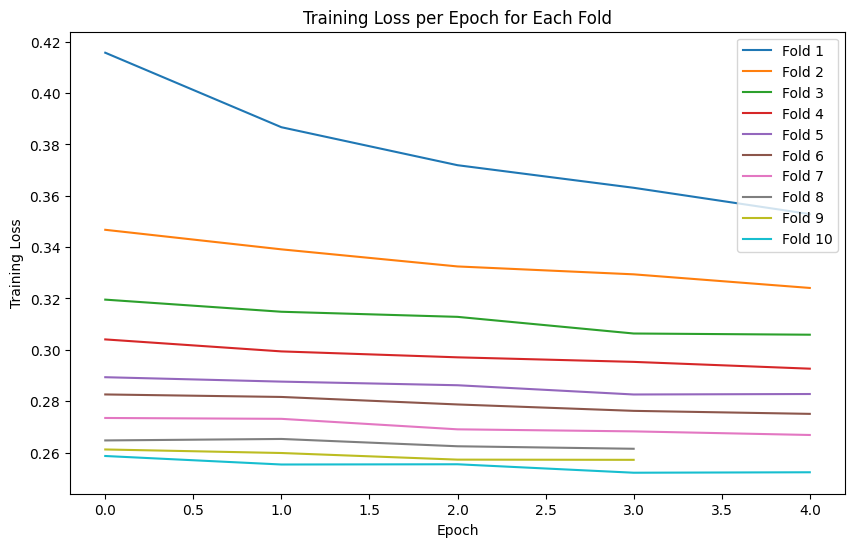

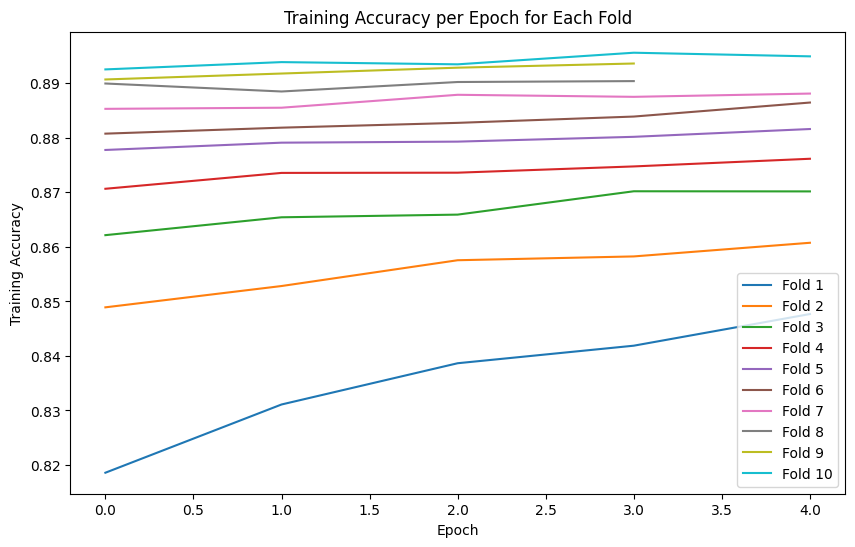

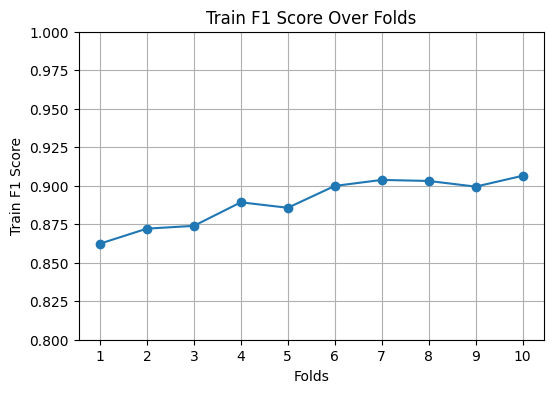

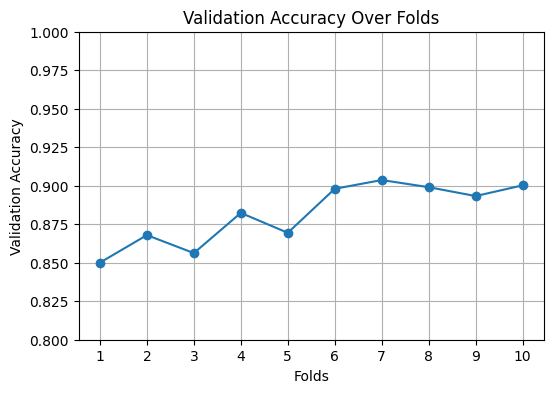

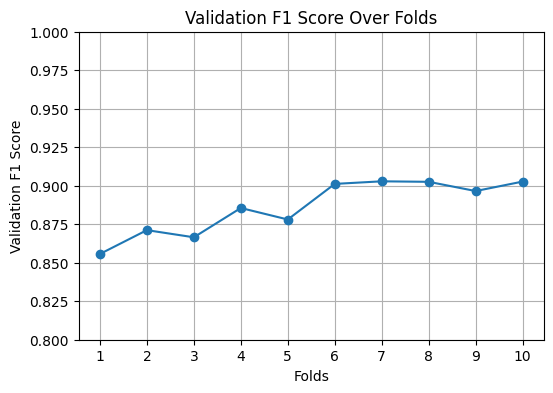

In [68]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')

plot_k_folds_metrics(train_loss_history, 'Loss')
plot_k_folds_metrics(train_accuracies, 'Accuracy')
plot_train_f1_score(train_f1_scores, K_FOLDS, 'F1 Score')

plot_validation_graphs(val_accuracies, K_FOLDS, 'Accuracy')
plot_validation_graphs(val_f1_scores, K_FOLDS, 'F1 Score')